In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from scipy.sparse import load_npz

train_csr = load_npz('../train_user_csr.npz')
test_X_csr = load_npz('../testx_user_csr.npz')
test_y_csr = load_npz('../testy_user_csr.npz')

In [3]:
from scipy.sparse import csr_matrix

class RecommendationAlgorithm:
  def __init__(self):
    pass

  def fit(self, training_ratings: csr_matrix) -> None:
    # Train the model on the training ratings
    pass

  def predict(self, user_ratings: csr_matrix) -> csr_matrix:
    # Predict the ratings for the given users and items
    pass

In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer

class KNNAlgorithm(RecommendationAlgorithm):
  def __init__(self, n_neighbors=5, distance_metric='cosine', weight_by_idf=False, normalizer=None):
    self.nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric=distance_metric)
    self.normalizer = normalizer
    if weight_by_idf:
      self.transformer = TfidfTransformer(norm=normalizer)
    self.train = []
    self.weight_by_idf = weight_by_idf

  def fit(self, train: csr_matrix):
    # Train the model on the training ratings
    if self.weight_by_idf:
      _train = self.transformer.fit_transform(train)
    self.train = train
    self.nn_model.fit(_train)

  def predict(self, seen: csr_matrix, n=500):
    # Predict the ratings for the given users and items
    if self.weight_by_idf:
      _seen = self.transformer.transform(seen)
    neighbors = self.nn_model.kneighbors(_seen, return_distance=False)
    predicted_ratings = []
    for (user_idx, user_neighbors_idx) in enumerate(neighbors):
      averages = np.ravel(self.train[user_neighbors_idx, :].mean(axis=0))
      already_added = np.sort(seen.indices[seen.indptr[user_idx]:seen.indptr[user_idx+1]])
      averages[already_added] = -1
      topn = np.argpartition(-averages, n)[:n]
      predicted_ratings.append(topn[np.argsort(-averages[topn])])
    return predicted_ratings


In [5]:
np.seterr(divide='ignore', invalid='ignore')

model = KNNAlgorithm(n_neighbors = 100, distance_metric = 'cosine', weight_by_idf=True, normalizer='l2')
model.fit(train_csr)

In [6]:
def batch_generator(a:csr_matrix, b:csr_matrix, batch_size:int = 1000):
    num_samples = a.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)

        yield a[start_idx:end_idx], b[start_idx:end_idx]

In [7]:
batch_size = 1000
batch_gen = batch_generator(test_X_csr, test_y_csr, batch_size)

pred = []
actual = []

batch_gen = batch_generator(test_X_csr, test_y_csr, 1000)

for seen, unseen in batch_gen:
  nnz = unseen.nonzero()
  actual.extend([nnz[1][nnz[0] == i].tolist() for i in range(unseen.shape[0])])

  batch_pred = model.predict(seen)
  pred.extend(batch_pred)

In [8]:
from evaluation import mean_avg_precision

print("MAP: {:.4f}".format(mean_avg_precision(pred, actual)))

MAP: 0.2132


In [9]:
from evaluation import mean_avg_recall

print("MAR: {:.4f}".format(mean_avg_recall(pred, actual)))

MAR: 0.8862


In [10]:
from evaluation import precision_at_k

for k in [5,10,20,50,100,200,300,400,500]:
    recall = precision_at_k(pred, actual, k)
    print("Precision@{}: {:.4f}".format(k, recall))

Precision@5: 0.2390
Precision@10: 0.1821
Precision@20: 0.1292
Precision@50: 0.0775
Precision@100: 0.0500
Precision@200: 0.0304
Precision@300: 0.0221
Precision@400: 0.0174
Precision@500: 0.0143


In [11]:
from evaluation import recall_at_k

for k in [5,10,20,50,100,200,300,400,500]:
    recall = recall_at_k(pred, actual, k)
    print("Recall@{}: {:.4f}".format(k, recall))


Recall@5: 0.1304
Recall@10: 0.1969
Recall@20: 0.2781
Recall@50: 0.4146
Recall@100: 0.5330
Recall@200: 0.6472
Recall@300: 0.7045
Recall@400: 0.7394
Recall@500: 0.7620


In [12]:
from evaluation import true_positives, false_negatives, false_positives

tp = sum([true_positives(x,y) for x, y in zip(pred, actual)])
fp = sum([false_positives(x,y) for x, y in zip(pred, actual)])
fn = sum([false_negatives(x,y) for x, y in zip(pred, actual)])

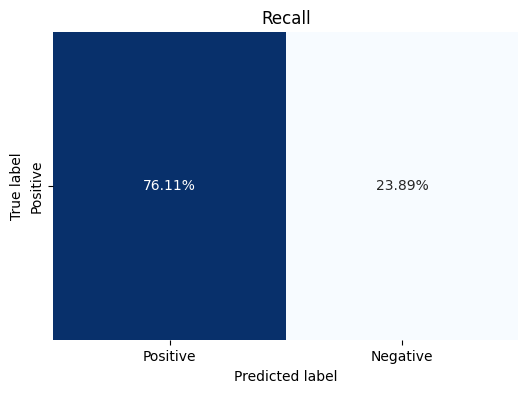

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap([[tp/(tp+fn), fn/(tp+fn)]], annot=True, fmt = '.2%', cmap='Blues', cbar=False,
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive'])
plt.title('Recall')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

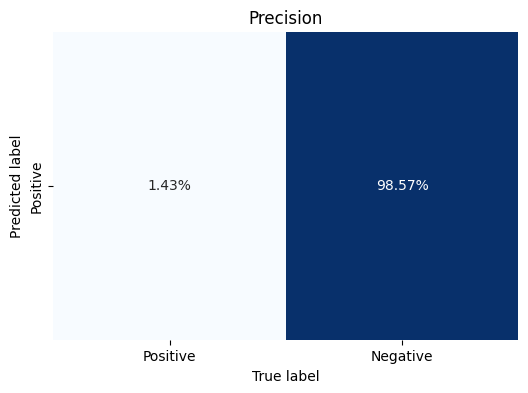

In [16]:
plt.figure(figsize=(6, 4))
sns.heatmap([[tp/(tp+fp), fp/(tp+fp)]], annot=True, fmt = '.2%', cmap='Blues', cbar=False,
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive'])
plt.title('Precision')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [15]:
np.save('cf_knn_candidates', pred)